## How to train your model

In [1]:
from fastai.basics import *
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math
import matplotlib as mpl
import torch
import matplotlib.pyplot as plt
from torch import tensor

import time

def timeit(func):
    def wrapper(*args, **kwargs):
        now = time.time()
        retval = func(*args, **kwargs)
        print('{} took {:.5f}s'.format(func.__name__, time.time() - now))
        return retval
    return wrapper


# if not exist, download mnist dataset
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

In [17]:
def get_data():
    path = "/work2/05515/bflynn/frontera/data/mnist.pkl.gz"
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

In [18]:
def normalize(x, m, s): return (x-m)/s

In [19]:
x_train,y_train,x_valid,y_valid = get_data()

In [23]:
x_train.shape

torch.Size([50000, 784])

In [22]:
y_train.shape

torch.Size([50000])

In [24]:
x_valid.shape

torch.Size([10000, 784])

In [25]:
y_valid.shape

torch.Size([10000])

In [47]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

In [48]:
x_train = normalize(x_train, train_mean, train_std)
# NB: Use training, not validation mean for validation set
# Why? If you normalize the two datasets with differently, they'll be on 
# totally different scales from one another - won't be able to tell 
# the differences between images in both sets 
x_valid = normalize(x_valid, train_mean, train_std)

In [51]:
mpl.rcParams['image.cmap'] = 'gray'

In [52]:
img = x_train[0]

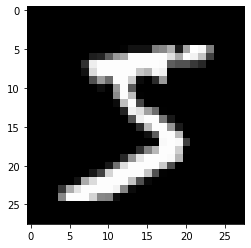

In [53]:
plt.imshow(img.view((28,28)));

# Why the hell do inits matter?

And why you need a good one

In [26]:
x = torch.randn(512)
a = torch.randn(512,512)

In [27]:
for i in range(100): x = a @ x

In [28]:
x.mean(), x.std()

(tensor(nan), tensor(nan))

### What the heck happened? Activation explosion!
Let's ask the loop to break when our activations explode

In [29]:
x = torch.randn(512)
a = torch.randn(512,512)

In [30]:
for i in range(100):
    x = a @ x
    if x.std() != x.std(): break

In [31]:
i

28

It only takes 28 iterations until our activations explode!

What about if we initialize our activations with a scale that is really low?

In [32]:
x = torch.randn(512)
a = torch.randn(512,512)*0.01

In [33]:
for i in range(100): x = a @ x

In [34]:
x.mean(), x.std()

(tensor(0.), tensor(0.))

So now every activation has vanished, to zero. **This is the reason why we couldn't train deep neural networks for so long - initializing them is challenging and you need to pick the right initialization or your activations get too big to handle (nan) or vanish entirely!**

Some strategies to properly initialize - 

- use stdev that will make sure x and ax have the *same* scale
- orthogonal matrix initializes weight, so x and ax would have same sum of squares by preserving the L2 norm
- spectral normalization on matrix A (spectral norm is least possible number M such that ```torch.norm(A@x) <= M*torch.norm(x)``` so dividing A by this M insures you don't overflow. You can still vanish with this)

# Xavier initialization

TLDR: scale equal to ```1/math.sqrt(n_in)```, where ```n_in``` is the **number of inputs of our matrix**.

In [35]:
import math

x = torch.randn(512)
a = torch.randn(512,512)/math.sqrt(512)

In [36]:
for i in range(100): x = a @ x

In [37]:
x.mean(), x.std()

(tensor(0.0022), tensor(0.3076))

# Kaiming initialization

PyTorch kaiming init for reference ( just an example )

In [22]:
nh = 32 # number of hidden layers just an example
l1 = nn.Conv2d(1, nh, 5)

In [25]:
nn.init.kaiming_normal_(l1.weight, a=1.);

# All you need is a good init - paper

In [38]:
# layering matrix multiplication, relu, fully connect it forward and then backward to pass back the gradients

In [41]:
# Model Data (vars initialized above)

In [39]:
n, m = x_train.shape
c = y_train.max()+1
nh = 50

In [40]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [42]:
model = Model(m, nh, 10)

In [43]:
pred = model(x_train)

In [13]:
# Need a loss function, without it we can't train

# Cross Entropy Loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [14]:
# in code form: 

def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [54]:
sm_pred = log_softmax(pred)

In [55]:
# when you multiply by zero in a one hot encoded vector, doing nothing and also slow
# faster way - what is the location of what you care about? which is one
# Use the index of our actual! (the one in a one hot encoded matrix or vector)

In [57]:
y_train[:3]

tensor([5, 0, 4])

In [58]:
sm_pred.shape # sm = softmax predictions
# 50,000 for all images in training set, 10 for number of pred categories

torch.Size([50000, 10])

In [60]:
sm_pred[0][5]

tensor(-2.3908, grad_fn=<SelectBackward>)

In [63]:
sm_pred[[0,1,2], [5,0,4]] 
# works because pytorch does numpy advanced indexing!
# integer array indexing

# can pass a list for each dimension(2 dims, 2 lists)
# first is the row indexes you want
# second is the column indexes you want

# returns 0,5 - 1,0 - 2,4
# check that above and below 0,5 are the same

tensor([-2.3908, -2.1919, -2.3700], grad_fn=<IndexBackward>)

In [62]:
y_train.shape[0]

50000

In [64]:
# negative log likelihood function
def nll(input, target): return -input[range(target.shape[0]), target].mean()

# all row indexes, and targets is columns we want
# include "-" before input - because negative log likelihood
# then, take the mean

In [66]:
# loss is the negative log likelihood of softmax predictions, compared 
# to actual training (y_training)

loss = nll(sm_pred, y_train)

In [67]:
loss

tensor(2.3209, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [68]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [69]:
# when you go x.exp() - can get very big numbers
# huge numbers in floating numbers on a computer, wildly inprecise
# computer could thing two huge numbers 1000 apart are exactly the same

In [70]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:, None]).exp().sum(-1).log()

### In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

____

# Basic Training

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [71]:
loss_func = F.cross_entropy

In [72]:
def accuracy(out, yb): return (torch.argmax(out, dim=1) == yb).float().mean()
# grab argmax, which number in softmax is highest, index of that is our prediction
# (index would be what category was predicted in the one hot encoded matrix)
# check whether that's equal to the actual
# take the mean, convert it to a float first (can't take mean of int in pytorch)

In [73]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.0953, -0.4574, -0.0707,  0.2429,  0.1801, -0.2620, -0.2129, -0.0346,
         -0.2923, -0.1401], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [74]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3405, grad_fn=<NllLossBackward>)

In [75]:
accuracy(preds, yb) 
# haven't trained our model yet, so the accuracy based on the 
# randomly initialized parameters is 10 ish percent

tensor(0.1094)

In [76]:
lr = 0.5 # learning rate
epochs = 1 # how many epochs to train for

## Training loop

- calculate predictions
- calculate your loss
- do backward pass
- **subtract learning rate times gradients**
- and then **zero the gradients**

In [77]:
for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i : end_i]
        yb = y_train[start_i : end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad*lr
                    l.bias -= l.bias.grad*lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [78]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2886, grad_fn=<NllLossBackward>), tensor(0.8750))

# Using parameters and optim

In [81]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            ## with torch.no_grad() refactoring, replace with
            # model.parameters
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [82]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2886, grad_fn=<NllLossBackward>), tensor(0.8750))

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [79]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        # every time set an attribute, update a list of _modules wiht list of all modules I have
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [80]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [83]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__() ## it has to set up dummy modules _modules dictionary
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [84]:
model = Model(m, nh, 10)

In [85]:
for name, l in model.named_children(): print(f"{name}:{l}")

l1:Linear(in_features=784, out_features=50, bias=True)
l2:Linear(in_features=50, out_features=10, bias=True)


In [86]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

# Registering modules

In [87]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [88]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__() # needed to set up module dictionary
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [89]:
model = Model(layers)

In [90]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## nn.ModuleList

In [91]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [92]:
model = SequentialModel(layers)

In [93]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [94]:
nn.Sequential??

# Optim

**Further refactoring**

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [95]:
class Optimizer():
    def __init__(self, params, lr=0.5): 
        self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
                
    # select only parameters that you want to optimize, and zero 
    # their gradients

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [96]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [97]:
opt = Optimizer(model.parameters())

In [98]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [99]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.5057, grad_fn=<NllLossBackward>), tensor(0.8750))

In [100]:
from torch import optim

In [101]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [102]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.2665, grad_fn=<NllLossBackward>)

In [105]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [106]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1089, grad_fn=<NllLossBackward>), tensor(0.9375))

In [107]:
assert acc>0.7

# When you're developing ...

Don't set a random seed - if there's variation going on in the model at different times, we want to see it. 

#### Don't want it to be shielded by setting one random seed that works well

Though reproducibility is key, great for doing science, not how you should develop your models at the beginning. Developing your models, you want intuitive sense of:
- is it stable?
- how much variation do you expect?

If you have a test where it fails every 100 times, you want to know that! 

Can help with verifying stability and working to improve stability

# Dataset and DataLoader

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [108]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x) # len of something - length of dataset now stored
    def __getitem__(self, i): return self.x[i],self.y[i] # return tuple of x[i] and y[i]